The FFT provides you with amplitude and phase. The amplitude is encoded as the magnitude of the complex number (sqrt(x^2+y^2)) while the phase is encoded as the angle (atan2(y,x)). To have a strictly real result from the FFT, the incoming signal must have even symmetry (i.e. x[n]=conj(x[N-n])).

If all you care about is intensity, the magnitude of the complex number is sufficient for analysis.
https://stackoverflow.com/questions/10304532/why-does-fft-produce-complex-numbers-instead-of-real-numbers#:~:text=The%20FFT%20provides%20you%20with%20amplitude%20and%20phase.&text=Those%20complex%20numbers%20in%20the,or%20magnitude%20and%20a%20phase).

In [44]:
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt


In [45]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)


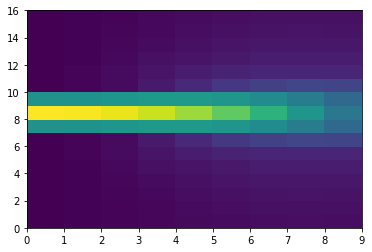

In [46]:
audio_binary = tf.io.read_file("data/output-0334.wav")
waveform = decode_audio(audio_binary)
spectrogram = tf.signal.stft(
      waveform, frame_length=2048,frame_step=128)

import statistics
s = tf.abs(spectrogram)
new = np.array([])
max_n = 0
maxes = []
for frame in s:
    maxes.append(tf.math.argmax(frame))
    #print(tf.math.argmax(frame))
    



median_max = statistics.median(maxes)

s = tf.slice(s,
               begin=[0, median_max - 8],
               size=[-1, 16])
plt.pcolormesh(s.numpy().T)

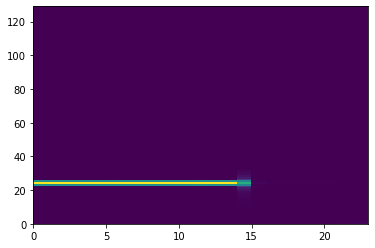

In [47]:
audio_binary = tf.io.read_file("data/output-0334.wav")
waveform = decode_audio(audio_binary)
spectrogram = tf.signal.stft(
      waveform, frame_length=256,frame_step=128)

plt.pcolormesh(tf.abs(spectrogram.numpy().T))

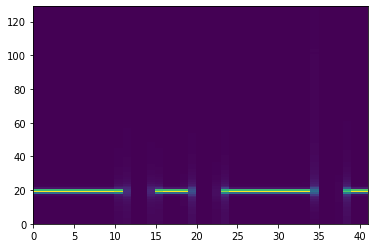

In [48]:
audio_binary = tf.io.read_file("data/C.wav")
waveform = decode_audio(audio_binary)
spectrogram = tf.signal.stft(
      waveform, frame_length=256,frame_step=128)

plt.pcolormesh(tf.abs(spectrogram.numpy().T))

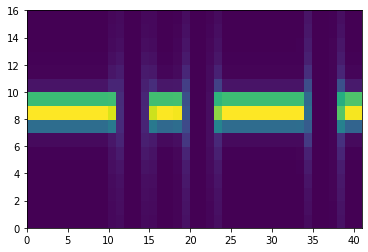

In [49]:
import statistics
s = tf.abs(spectrogram)
new = np.array([])
max_n = 0
maxes = []
for frame in s:
    maxes.append(tf.math.argmax(frame))
    #print(tf.math.argmax(frame))
    



median_max = statistics.median(maxes)

s = tf.slice(s, begin=[0, median_max - 8], size=[-1, 16])
plt.pcolormesh(s.numpy().T)

In [50]:
max_n

0

In [110]:
def get_spectrogram_tf(waveform):
  # Padding for files with less than 256000 samples
  #print("Len: {}".format(tf.shape(waveform)))
  zero_padding = tf.zeros([100000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  get_max(spectrogram)
  spectrogram = tf.abs(spectrogram)
  maxes = get_max(spectrogram)

  # Remove any zeros from the "maxes"  
  boolean_mask = tf.cast(maxes, dtype=tf.bool)              
  no_zeros = tf.boolean_mask(maxes, boolean_mask, axis=0)
  median_max = statistics.median(no_zeros)
    
  # cast properly for the tf.slice command
  median_max = tf.cast(median_max, tf.int32)


  #tf.print("median max: ", median_max)
  #print("Median: {}".format(median_max))
  spectrogram = tf.slice(spectrogram, begin=[0, median_max - 8], size=[-1, 16])

  return spectrogram



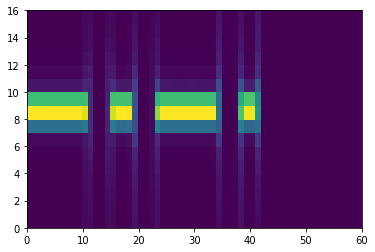

In [111]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# TensorFlow compatible function for determining the peak frequency
def get_max(spectrogram):  
    max_seq_len = spectrogram.shape[1]
    maxes = tf.TensorArray(tf.int64, size=max_seq_len)
    for i in tf.range(max_seq_len):
        max_n = tf.math.argmax(tf.cast(spectrogram[i], tf.int64))
        maxes = maxes.write(i, max_n)
    return maxes.stack()

with tf.device('/GPU'):
    audio_binary = tf.io.read_file("data/C.wav")
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram_tf(waveform)
    plt.xlim(0,60)
    plt.pcolormesh(tf.abs(spectrogram.numpy().T))
    

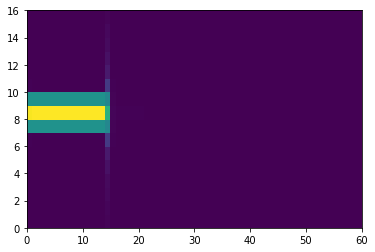

In [112]:
    audio_binary = tf.io.read_file("data/output-0334.wav")
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram_tf(waveform)
    plt.xlim(0,60)
    plt.pcolormesh(tf.abs(spectrogram.numpy().T))